In [1]:
from collections import Counter
from scratch.linear_algebra import distance, subtract, scalar_multiply
from functools import reduce
import math, random

In [2]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

In [3]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

In [4]:
def plot_estimated_derivative():
    def square(x):
        return x * x
    def derivative(x):
        return 2 * x
    derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)
# plot to show they're basically the same
    import matplotlib.pyplot as plt
    x = range(-10,10)
    plt.plot(x, list(map(derivative, x)), 'rx', label='Actual') # red x
    plt.plot(x, list(map(derivative_estimate, x)), 'b+', label='Estimate') # blue +
    plt.legend(loc=9)
    plt.title('Actual vs Estimate')
    plt.show() 

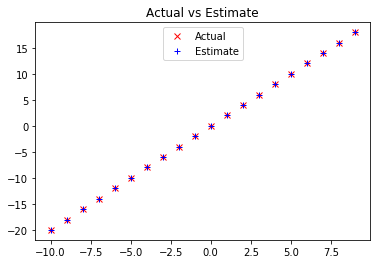

In [5]:
%matplotlib inline
plot_estimated_derivative()

Numerical gradient

When f is a function of many variables, it has multiple partial derivatives, each indicating how f changes
when we make small changes in just one of the input variables.
We calculate its ith partial derivative by treating it as a function of just its ith variable, holding the other
variables fixed:

In [6]:
def partial_difference_quotient(f, v, i, h):
 # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
    for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h

In [7]:
def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

In [8]:
estimate_gradient(sum_of_squares, [1.,1.,1])

[2.00001000001393, 2.00001000001393, 2.00001000001393]

In [9]:
import numpy as np
def estimate_gradient_np(f, v, h=0.00001):
    return (np.apply_along_axis(f, 1, v + h * np.eye(v.shape[0])) - f(v)) / h

In [10]:
estimate_gradient_np(lambda v: np.sum(v * v), np.array([1.,1.,1]))

array([2.00001, 2.00001, 2.00001])

Using the Gradient

The sum_of_squares function is smallest when its input v is a vector of zeros.
We want to verify the fact using gradient descent.
(Gradient descent) Let’s use gradients to find the minimum among all three-dimensional vectors. We’ll
just pick a random starting point and then take tiny steps in the opposite direction of the gradient until we
reach a point where the gradient is very small

In [11]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
    for v_i, direction_i in zip(v, direction)]
def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]


In [12]:
def step_np(v, direction, step_size):
    """move step_size in the direction from v"""
    return v + step_size * direction
def sum_of_squares_gradient_np(v):
    return 2 * v

In [13]:
print("using the gradient")
v = [random.randint(-10,10) for i in range(3)]
tolerance = 0.0000001
while True:
 #print(v, sum_of_squares(v))
    gradient = sum_of_squares_gradient(v) # compute the gradient at v
    next_v = step(v, gradient, -0.01) # take a negative gradient step
    if distance(next_v, v) < tolerance: # stop if we're converging
        break
    v = next_v # continue if we're not
print("minimum v", v)
print("minimum value", sum_of_squares(v))
print()

using the gradient
minimum v [-4.816976178530657e-07, 4.335278560677595e-06, -2.4084880892653316e-06]
minimum value 2.4827487669849083e-11



Choosing the Right Step Size (or Learning rate)

Although the rationale for moving against the gradient is clear, how far to move is not. Indeed, choosing the
right step size is more of an art than a science. Popular options include:
Using a fixed step size
Gradually shrinking the step size over time
At each step, choosing the step size that minimizes the value of the objective function
The last sounds optimal but is, in practice, a costly computation. We can approximate it by trying a variety of
step sizes and choosing the one that results in the smallest value of the objective function:

In [14]:
step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

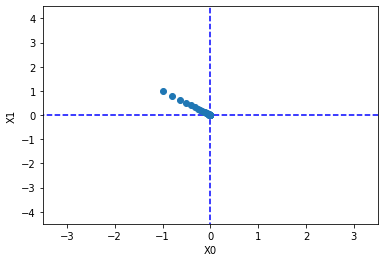

In [15]:
import numpy as np
import matplotlib.pyplot as plt
def sum_of_squares_gradient_np(v):
    return 2 * v
def gradient_descent(gradient_f, init_x, lr=0.01, step_num=10000, tolerance=0.0000001):
    x = init_x
    x_history = []
    for i in range(step_num):
        x_history.append(x.copy())
        x_prev = x.copy()
        x -= lr * gradient_f(x)
        if np.linalg.norm(x - x_prev) < tolerance: # stop if we're converging
            break
    return x, x_history#!! indenting 잘못해서!!!
    
init_x = np.array([-1.0, 1.0])

lr = 0.1# try with 10, 1.1, 1, 0.1, 0.01
step_num = 100 
x, x_history = gradient_descent(sum_of_squares_gradient_np, init_x, lr=lr, step_num=step_num)
plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
x_history = np.array(x_history)
plt.plot(x_history[:,0], x_history[:,1], 'o')
plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [16]:
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf') # this means "infinity" in Python
    return safe_f


Putting It All Together

In the general case, we have some target_fn that we want to minimize, and we also have its gradient_fn . For
example, the target_fn could represent the errors in a model as a function of its parameters, and we
might want to find the parameters that make the errors as small as possible.

In [17]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0 # set theta to initial value
    target_fn = safe(target_fn) # safe version of target_fn
    value = target_fn(theta) # value we're minimizing
    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                    for step_size in step_sizes]
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

Example : Minimizing sum_of_squares

In [18]:
minimize_batch(sum_of_squares, sum_of_squares_gradient, [10,20,4,5])

[0.0006805647338418772,
 0.0013611294676837543,
 0.00027222589353675085,
 0.0003402823669209386]

In [19]:
minimize_batch(sum_of_squares, sum_of_squares_gradient, [10,20,4,5,0,1])

[0.0006805647338418772,
 0.0013611294676837543,
 0.00027222589353675085,
 0.0003402823669209386,
 0.0,
 6.805647338418771e-05]

Example : Centering a certain point

In [20]:
def myf(v):
    return (v[0]-3)**2 + (v[1]-2)**2
def myf_gradient(v):
    return [2.0*v[0]-6, 2.0*v[1]-4]
minimize_batch(myf, myf_gradient, [5000.,50.])

[3.0016059738814325, 2.000015426605225]

In [21]:
from functools import partial
def f1(x, c):
    x = np.array(x)
    c = np.array(c)
    return np.sum((x - c)**2)
def f1_gradient(x, c):
    x = np.array(x)
    c = np.array(c)
    return 2*x - 2*c
def numerical_gradient(v, f, h=0.00001):
    return (f(v) - np.apply_along_axis(f, 1, v - h * np.eye(len(v)))) / h
c = np.array([7,70,7,4])
f = partial(f1, c=c)
#gradient_f = partial(numerical_gradient, f=f)
gradient_f = partial(f1_gradient, c=c)
minimize_batch(f, gradient_f, [0,0,0,0])

[6.999843894783611, 69.99843894783609, 6.999843894783611, 3.9999107970192056]

In [22]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)
def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                            negate_all(gradient_fn),
                            theta_0,
                            tolerance)

In [23]:
from functools import partial
def normal_pdf(npx, mu, sigma):
    x = npx[0]
    return ((1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))))
def numerical_gradient(v, f, h=0.00001):
    return (np.apply_along_axis(f, 1, v + h * np.eye(len(v))) - f(v)) / h
f = partial(normal_pdf, mu=0, sigma=1)
gradient_f = partial(numerical_gradient, f=f)
init_x = np.array([-4.])
maximize_batch(f, gradient_f, init_x)

[-0.0023954427570109793]

In [24]:
#
# minimize / maximize stochastic
#
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)] # create a list of indexes
    random.shuffle(indexes) # shuffle them
    for i in indexes: # return the data in that order
        yield data[i]

Understanding SGD Code

x is a training data set
y is a label (or class) set


In [25]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = list(zip(x, y))
    theta = theta_0 # initial guess
    alpha = alpha_0 # initial step size
    min_theta, min_value = None, float("inf") # the minimum so far
    iterations_with_no_improvement = 0
# if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )
        if value < min_value:
        # if we've found a new minimum, remember it
        # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
# otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
# and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
    return min_theta

In [26]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
 negate_all(gradient_fn),
x, y, theta_0, alpha_0)